### Mallet Implementation

In [22]:
# Required Packages
# Refer to team guides for installing

import re
import pandas as pd
import numpy as np
from pprint import pprint
import spacy
from nltk.stem import WordNetLemmatizer
import nltk; nltk.download('stopwords')
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
# %matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /Users/jihok/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Cleaning Steps

Prior to using the data sources, they must be cleaned and prepared. Two functions, utilizing regular expression, were developed and used to remove unnecessary characters found in the ServiceNow datasets. Further edits can be made to the cleaning process as needed or requested.

In [24]:
# FUNCTIONS APPLY CURRENT CLEANING STEPS INTO ENTIRE DATASET

def subject_clean(subject_line):
    """Remove all unnecessary characters from Description column for each dataset row"""
    regex_sol = re.sub(r'https?://\S+', '', subject_line) # removes URL links
    regex_sol = re.sub(r"\S*@\S*\s?", "", regex_sol) # removes email accounts
    regex_sol = regex_sol.replace("\n", "").replace("< >","").replace("\r", "") # removes newline and <> and \r
    regex_sol = re.sub(r"\d+", "", regex_sol) # removes integers 
    regex_sol = re.sub(r"([^\s\w]|_)+", " ", regex_sol) # removes non-alphanumeric characters, but maintains whitespace
    regex_sol = regex_sol.encode("ASCII", "replace").decode("utf-8").replace("?", " ") # removes all non-ASCII characters
    regex_sol = regex_sol.lower() # lower case string
    return regex_sol

def case_line_clean(case_line):
    """Remove all unnecessary characters from Case column for each dataset row"""
    regex_sol_2 = re.sub(r"[?](CS)[0-9]+", "", case_line) # removes ending "?CS###"
    regex_sol_2 = re.sub(r"\d+", "", regex_sol_2) # removes integers
    regex_sol_2 = re.sub(r"([^\s\w]|_)+", " ", regex_sol_2) # removes non-characters, but maintains whitespace
    regex_sol_2 = regex_sol_2.lower()
    return regex_sol_2

An additional removal of any instance of "Spam" and "Other Buying Inquiry" were added as part of the dataset cleaning efforts.

In [ ]:
# call the dataset that pertains to you
august_dataset = pd.read_csv("SNOW August Data.csv", encoding = "ISO-8859-1")
september_dataset = pd.read_csv("SNOW September Data.csv", encoding = "ISO-8859-1")

#SPAM case removal
august_dataset = august_dataset.loc[(august_dataset['contact'] != 'Spam spam') 
                                    & (august_dataset['contact'] != 'SPAM SPAM') 
                                    & (august_dataset['resolution_code'] != 'Spam') 
                                    & (august_dataset['service_offering'] == 'Other Buying Inquiry')].reset_index(drop=True)

september_dataset = september_dataset.loc[(september_dataset['contact'] != 'Spam spam') 
                                          & (september_dataset['contact'] != 'SPAM SPAM') 
                                          & (september_dataset['resolution_code'] != 'Spam') 
                                          & (september_dataset['service_offering'] == 'Other Buying Inquiry')].reset_index(drop=True)

# Regex cleaning applied to both the "description" and "case" columns in each dataset
august_dataset['description'] = august_dataset['description'].apply(subject_clean)
september_dataset['description'] = september_dataset['description'].apply(subject_clean)

august_dataset['case'] = august_dataset['case'].apply(case_line_clean)
september_dataset['case'] = september_dataset['case'].apply(case_line_clean)

# Concat the cleaned data into one dataframe for use
# June annd July have been removed 
all_months = pd.concat([august_dataset, september_dataset]).reset_index()
# len(all_months) 631

Cases with "wav file" and "idt" were also removed as requested. Code below iterates through all_months and removes a total of 85 rows. 

In [26]:
delete_rows = []
for i in range(len(all_months)):
    curr = all_months.iloc[i]['description']
    test1 = re.findall(r"\b(wav.file)\b", curr)
    test2 = re.findall(r"\b(idt)\b", curr)
    if len(test1) > 0 or len(test2) > 0:
        delete_rows.append(i)

all_months = all_months.drop(delete_rows).reset_index(drop=True)

### Topic Modeling Work 

Resources: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

Stopwords are generated at this step in the project. The variable "domain_stop_words" is done by hand and includes words typically seen in ServiceNow cases. Additional words can be added here or from the additional_stopwords.ipynb for cleanliness. "domain_stop_words" is then added onto the downloaded stopwords from the nltk package.

In [28]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# Additional stopwords
domain_stop_words = [
    'hi', 'hello', 'thank', 'thanks', 'com', 'the', 're', 'php', 'http', 'XXXXXXXXX', 'would', 'however', 
    'please', 'do', 'can', 'may', 'check', 'pende', 'tell', 'use', 'call', 'let', 'dear', 'see', 'click', 
    'still', 'unable', 'even', 'minute', 'basically', 'seem', 'expect', 'pcie', 'usd', 'go', 'could', 
    'advise', 'appreciate', 'regard', 'also', 'end', 'sure', 'copy', 'phone', 'know', 'accidently', 
    'reply', 'web', 'soon', 'regard', 'get', 'try', 'new', 'follow', 'date', 'pm' ,'back', 'note', 'us', 
    'sku', 'sincerely', 'immediately', 'notify', 'one', 'two', 'someone', 'day', 'put', 'start', 'set', 
    'reply', 'advise', 'august', 'arise', 'therewith', 'regarding', 'san', 'diego', 'uc', 'inc', 'ca',
    'go', 'able', 'say', 'like', 'wav_file', 'ref', 'monday', 'marketplace', 'try', 'time', 'use','want',
    'ucsd','pur', 'support', 'provide', 'question','darmstadt', 'germany', 'accept', 'liability','office',
    'subject', 'email','sent','confidential','attachment','say','pdf','sender', 'comments','v', 'customer',
    'services', 'abcam','kendall','square','suite','cambridge', 'usatoll','free','international','tel','fax',
    'hours','est','mon','frigoods','duties','unpaid','control','placing','agreeing','duties','applicable', 
    'wondering', 'happens', 'something', 'janelle', 'chartstream', 'needs', 'believe', 'attached', 'cce', 
    'zhu', 'rm', 'ste', 'cd', 'going', 'received', 'much', 'kind', 'regards', 'drydock', 'avenueboston', 
    'linethank', 'ab', 'from'
    ]      

# if stop_words_blk_1 is empty, cell will run lines under inside "except" 
# to add additional stopwords go to "additional_stopwords.ipynb"
try:
    # retreives additional stop words from additional_stopwords notebook
    %store -r stop_words_blk_1
    stop_words.extend(domain_stop_words+stop_words_blk_1)   
except:
    # retreives additional stop words 
    stop_words.extend(domain_stop_words)

In [30]:
print(len(stop_words))

3958


#### Tokenization of Words

The "description" column is now tokenized to have their sentences broken down and separated into a list of words. The result lists of words is stored in the variable "text_words".

In [34]:
# Dividing description into individual words aka tokenizing
alldescrip = list(all_months['description'])

#initiate blank list
text_words = []

#for loop to tokenize all words in
for sentence in alldescrip:
    temp = gensim.utils.simple_preprocess(sentence)
    text_words.append(temp)

#### Biagram Creation

Words that frequently occur together in the variable "text_words" are built using the gensim package here. 
Consult resource link above for further details.

In [36]:
# Build the bigram
bigram = gensim.models.Phrases(text_words, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

#### Stopword Removal, Biagram Constructed, Lemmatization Occurs

The stopwords stored earlier are now being used to remove instances of the stopwords found in the variable "text_words". A bigram model is also constructed here.

In [38]:
#Removeal of stop words
text_words_no_stops = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in text_words]

#Make texts into bigram model
text_words_no_stops_bigram = [bigram_mod[doc] for doc in text_words_no_stops]

Lemmatization process occurs here. Spacy was used in the online tutorial, but was not used for our purposes with the reason being that the results of the lemmatization being better not using spacy.

In [42]:
# Lemmatize with POS Tag
# Ex: dance and dancing == dance 
# Grouping words
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


# return POS tag for next function
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [44]:
# Lemmatizing function 
# takes in full list of descriptions with stop words removed
# returns descriptions lemmatized
def lemm(text_stop_no_bigram):
    count = 0
    out = []
    for descrip in text_stop_no_bigram:
        count += 1
        inner = []
        for word in descrip:
            pos = get_wordnet_pos(word)
            inner.append(lemmatizer.lemmatize(word, pos))
        out.append(inner)
    return out


In [46]:
# Lemmatizes 
nltk.download('wordnet')
lemmed = (lemm(text_words_no_stops_bigram))
#lemmed[0]

[nltk_data] Downloading package wordnet to /Users/jihok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Dictionary and Corpus Creation for Topic Model

A dictionary and corpus are created as they serve as the inputs for the LDA model. Both created variables use the variable "lemmed" from previous lines of code.

In [50]:
#Create Dictionary
id2word = gensim.corpora.Dictionary(lemmed)

#Create Corpus
texts = lemmed

#Build Term Document Frequency (TDF)
corpus = [id2word.doc2bow(text) for text in texts]

In [52]:
# Read Corups/TDF per case
# Uncomment line below to observe word frequency
# WARNING: list is huge
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus]

#### Building Topic Model and Visualization (Mallet)

Constructing LDA model, but using Mallet instead of Gensim. Tutorial still being implemented and followed.

In [58]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# make sure to put the zip file into the same directory/path as your notebook, otherwise you'll get a directory/path related error
mallet_path =  'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=6, id2word=id2word)

Topics and their associated keywords are generated much like what was done previously. A coherence score is also calculated to judge the results of the topics. Compared to Gensim, the coherence score is greater than the one generated by Gensim. The text data used here has not been changed and is the exact same one used during the Gensim procedures.

In [59]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=lemmed, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('order', 0.33122362869198313),
   ('po', 0.05959915611814346),
   ('supplier', 0.05168776371308017),
   ('change', 0.0490506329113924),
   ('document', 0.047995780590717296),
   ('description', 0.034282700421940926),
   ('procurement', 0.03164556962025317),
   ('requisition_req', 0.029535864978902954),
   ('attachment', 0.026371308016877638),
   ('requisition', 0.022151898734177215)]),
 (1,
  [('message', 0.15638629283489097),
   ('inquiry', 0.07133956386292835),
   ('error', 0.06355140186915888),
   ('content', 0.05358255451713396),
   ('update', 0.05358255451713396),
   ('transmission', 0.05264797507788162),
   ('result', 0.05046728971962617),
   ('subsidiary', 0.048598130841121495),
   ('intended_recipient', 0.03489096573208723),
   ('delete', 0.030218068535825544)]),
 (2,
  [('information', 0.0643588493417845),
   ('product', 0.04193076548025353),
   ('ship', 0.03169185763042418),
   ('order', 0.02925402242808386),
   ('price', 0.02779132130667967),
   ('receive', 0.025353

#### Optimal Number of Topics for LDA

Using the tutorial, a function is written to find which number of topics produces the best coherence score. The arguments in this function allow for customization in terms of the number of topics that want to be tested. 

In [60]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [61]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=lemmed, start=2, limit=20, step=4)

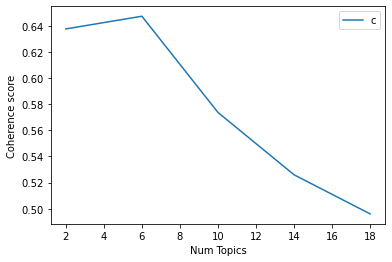

In [62]:
# Show graph
limit=20; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

The results of the testing are shown below. This can change depending on the number of topics tested and how many actually want to have a coherence score (check the "step" argument found in the function)

In [63]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6376
Num Topics = 6  has Coherence Value of 0.6473
Num Topics = 10  has Coherence Value of 0.5737
Num Topics = 14  has Coherence Value of 0.526
Num Topics = 18  has Coherence Value of 0.4961


In [64]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.200*"order" + 0.081*"ship" + 0.071*"product" + 0.047*"price" + '
  '0.028*"shipping" + 0.026*"lifespan" + 0.025*"week" + 0.023*"issue" + '
  '0.021*"antibody" + 0.020*"additional"'),
 (1,
  '0.202*"document" + 0.153*"purchasing" + 0.132*"purchase" + 0.129*"file" + '
  '0.069*"review" + 0.055*"number" + 0.030*"case" + 0.018*"follow" + '
  '0.018*"purreview" + 0.018*"department"'),
 (2,
  '0.109*"number" + 0.069*"service" + 0.053*"company" + 0.052*"fedex" + '
  '0.048*"track" + 0.046*"business" + 0.043*"delivery" + 0.039*"shipment" + '
  '0.033*"status" + 0.033*"deliver"'),
 (3,
  '0.141*"po" + 0.082*"invoice" + 0.081*"oracle" + 0.054*"vendor" + '
  '0.054*"payment" + 0.049*"submit" + 0.036*"account" + 0.032*"find" + '
  '0.027*"make" + 0.024*"good"'),
 (4,
  '0.129*"message" + 0.102*"inquiry" + 0.092*"error" + 0.076*"content" + '
  '0.075*"transmission" + 0.072*"result" + 0.069*"subsidiary" + 0.048*"update" '
  '+ 0.040*"access" + 0.036*"virus"'),
 (5,
  '0.122*"information" +

#### Dominant Topic Search for Each Sentence

In [65]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=alldescrip):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


# data should be text_words_no_stops_bigram
# df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=text_words_no_stops_bigarm)
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=alldescrip)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.1356,"po, invoice, oracle, vendor, payment, submit, ...",hello when i place orders on project oracl...
1,1,3.0,0.1488,"po, invoice, oracle, vendor, payment, submit, ...",i have been having an issue with processing a ...
2,2,7.0,0.2243,"order, address, receive, sale, research, send,...",received from cce ref customer number dea...
3,3,0.0,0.1324,"order, ship, product, price, shipping, lifespa...",received from dear pur dept \tthis transacti...
4,4,3.0,0.1404,"po, invoice, oracle, vendor, payment, submit, ...",received from thank you for the above referen...
5,5,3.0,0.1475,"po, invoice, oracle, vendor, payment, submit, ...",hello under the chart string of the following...
6,6,9.0,0.1981,"contact, question, request, service, update, r...",received from please reply above this linetha...
7,7,9.0,0.1981,"contact, question, request, service, update, r...",received from please reply above this linetha...
8,8,9.0,0.1963,"contact, question, request, service, update, r...",received from please reply above this linetha...
9,9,9.0,0.1981,"contact, question, request, service, update, r...",received from please reply above this linetha...


#### Most Representative Document for Each Topic

For each topic, we can see the text that closely align with the topic as chosen by mallet. This allows us to infer if the ServiceNow tickets placed in each topic should actually be in the specific topic and allows us to understand what cases make up the topic. Trouble shooting can also be done using this step as it allows us to directly see the cases themselves.

In [67]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5381,"order, ship, product, price, shipping, lifespa...",received from to university of california s...
1,1.0,0.2998,"document, purchasing, purchase, file, review, ...",received from dear uc san diego thank you for...
2,2.0,0.5475,"number, service, company, fedex, track, busine...",received from fedex hi this shipment ...
3,3.0,0.3790,"po, invoice, oracle, vendor, payment, submit, ...",received from from andre perez sent friday ...
4,4.0,0.3257,"message, inquiry, error, content, transmission...",received from thank you for contacting millip...
5,5.0,0.5257,"information, requisition, place, tax, add, lin...",received from doctype html html head \t titl...
6,6.0,0.5189,"order, supplier, change, po, requisition_req, ...",received from document requester change orde...
7,7.0,0.4000,"order, address, receive, sale, research, send,...",received from sars cov igg elisa kits now av...
8,8.0,0.1998,"message, mail, system, intended_recipient, del...",received from hello please confirm the attach...
9,9.0,0.2504,"contact, question, request, service, update, r...",received from user date fri aug pdtthe...


#### Topic Distribution Across Documents

The resulting dataframe shows us the volume and distribution of topics found in our model. 

In [68]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,3.0,"po, invoice, oracle, vendor, payment, submit, ...",49.0,0.1000
1.0,3.0,"po, invoice, oracle, vendor, payment, submit, ...",53.0,0.1082
2.0,7.0,"order, address, receive, sale, research, send,...",30.0,0.0612
3.0,0.0,"order, ship, product, price, shipping, lifespa...",101.0,0.2061
4.0,3.0,"po, invoice, oracle, vendor, payment, submit, ...",81.0,0.1653
...,...,...,...,...
485.0,5.0,"information, requisition, place, tax, add, lin...",NaN,NaN
486.0,9.0,"contact, question, request, service, update, r...",NaN,NaN
487.0,7.0,"order, address, receive, sale, research, send,...",NaN,NaN
488.0,7.0,"order, address, receive, sale, research, send,...",NaN,NaN


In [82]:
idx_val = 2
curr_index_val = curr_topic.iloc[idx_val]
print('Topic Keywords: ' + curr_index_val['Topic_Keywords'])
print("------------")
print('Perc Contribution: ' + str(curr_index_val['Perc_Contribution']))
print("------------")
print("Case Description: ")
print(curr_index_val[0])

Topic Keywords: message, inquiry, error, content, transmission, result, subsidiary, update, access, virus
------------
Perc Contribution: 0.3181
------------
Case Description: 
received from  thank you for contacting milliporesigma  we have received your request and will respond as soon as possible  the reference number for your inquiry is c if you need to contact us immediately  please call  sincerely  the milliporesigma service team   please reply to this email directly if you have follow up questions or more details to update your original inquiry  this provides you the fastest way to update your inquiry                                    your initial message review the purchasing document and any files that are attached to the message this message and any attachment are confidential and may be privileged or otherwise protected from disclosure  if you are not the intended recipient  you must not copy this message or attachment or disclose the contents to any other person  if you hav